# Animal Shelter Outcome Analysis
This project focuses on finding the effects of type, gender, age, breed and fertility on the adoption/ transfer of animals. The analysis answers the following questions:

- What are the general outcomes?
- Can we spot seasonality in the adoption/ transfer trends?
- Do cats have more luck in getting adopted?
- Do male dogs & cats have a better shot at getting adopted than their female counterparts?
- What are the most prevelants breeds of animals in the shelter?
- Do people prefer sterile animals for a pet?
- Is age a factor?
- A few interesting analyses on insights found along the way

The dataset can be downloaded from [here](https://www.kaggle.com/c/shelter-animal-outcomes/data). 

In [2]:
import pandas as pd
df = pd.read_csv('shelter_outcome.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB


In [3]:
df.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

Only the `'Name'` and `'OutcomeSubType'` columns have missing values which does not affect the analysis. <br><br>
**Renaming columns:** Changing CamelCase columns to snake_case and getting rid of redundant details.

In [4]:
col_list =[]

for col in df.columns:
    col = col.lower()
    col = col.replace('animal', '')
    col = col.replace('uponoutcome', '')
    col = col.replace('outcome', 'outcome_')
    col_list.append(col)

df.columns = col_list
df.head()

,id,name,datetime,outcome_type,outcome_subtype,type,sex,age,breed,color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


**Date and time** information are given in the object format. Converting them to datetime to use in time series analysis later:

In [5]:
import datetime as dt
df['datetime'] = pd.to_datetime(df['datetime'])
df.dtypes

id                         object
name                       object
datetime           datetime64[ns]
outcome_type               object
outcome_subtype            object
type                       object
sex                        object
age                        object
breed                      object
color                      object
dtype: object

Analysing the outcome strength of the shelter by **year**:

In [6]:
df['year'] = pd.DatetimeIndex(df['datetime']).year
df['year'].value_counts().sort_index()

2013     2702
2014    11179
2015    11481
2016     1367
Name: year, dtype: int64

In [7]:
df['month'] = pd.DatetimeIndex(df['datetime']).month
for i in range(2013, 2017):
    print('Months in the year {}: '.format(i), end = '')
    print(df.loc[(df['year'] == i), 'month'].unique())

Months in the year 2013: [10 11 12]
Months in the year 2014: [ 2  7  4  5  6  1  8 11  9 12  3 10]
Months in the year 2015: [ 1  3  4  6 11  9  8 10  7  5 12  2]
Months in the year 2016: [2 1]


As mentioned [here](https://www.kaggle.com/c/shelter-animal-outcomes/data), the years 2013 and 2016 has values only for a few months. This can hinder the analysis of yearly adoption/ transfer trends. So the data from these **two years are removed** from furthur analysis.

In [8]:
df.drop(df[(df['year'] == 2013) | (df['year'] == 2016)].index, inplace = True)
years = df['year'].unique()
total = df.shape[0]

print('Now the dataset has values only for the years {0} and {1} with a total strength of {2} animals'.format(years[0], years[1], total))

Now the dataset has values only for the years 2014 and 2015 with a total strength of 22660 animals


## General analysis of the outcomes types:

### Outcome proportion analysis:

In [9]:
df['outcome_type'].value_counts().sort_index()/total

Adoption           0.396205
Died               0.007635
Euthanasia         0.058870
Return_to_owner    0.178597
Transfer           0.358694
Name: outcome_type, dtype: float64

It can be see that about 40% of the animals get adopted, 35% of them are transferred elsewhere, 5% of the animals are put to sleep and a negligible number of animals die in this shelter. Each of the above category has a designated `'outcome_subtype'` column that gives further information about them. Their analysis are as follows:

### Adoption subtype:

In [10]:
adoption = df[df['outcome_type'] == 'Adoption']
adoption['outcome_subtype'].value_counts(dropna=False)/adoption.shape[0]

NaN        0.812876
Foster     0.170305
Offsite    0.016708
Barn       0.000111
Name: outcome_subtype, dtype: float64

The adoption subtype has over 80% missing values which could mean that when a person is adopting an animal, the shelter leaves the subtype column empty. About 20% of the animals are sent to foster care as it is difficult to care of animals that need special attention in places like common shelters.

### Transfer subtype:

In [11]:
transfer = df[df['outcome_type'] == 'Transfer']
transfer['outcome_subtype'].value_counts(dropna=False)/transfer.shape[0]

Partner    0.828863
SCRP       0.170768
NaN        0.000246
Barn       0.000123
Name: outcome_subtype, dtype: float64

Over 80% of the animals seem to be transferred to a partnering shelter for various reason which will be analysed along the way.

### Euthanasia subtype:

In [12]:
euthanasia = df[df['outcome_type'] == 'Euthanasia']
euthanasia['outcome_subtype'].value_counts()/euthanasia.shape[0]

Suffering              0.658171
Aggressive             0.197151
Rabies Risk            0.048726
Behavior               0.048726
Medical                0.042729
Court/Investigation    0.003748
Name: outcome_subtype, dtype: float64

A majority of the animals that are put to sleep seem to be suffering and another portion of the animals which could not be put up for adopted/ taken care of due behaviour/ diseases hold reasonable grounds for addressing euthanasia.

### Death subtype:

In [13]:
death = df[df['outcome_type'] == 'Died']
death['outcome_subtype'].value_counts()/death.shape[0]

In Kennel     0.572254
In Foster     0.254335
Enroute       0.046243
At Vet        0.023121
In Surgery    0.017341
Name: outcome_subtype, dtype: float64

The subtypes for death seems to be for common reasons.

## Seasonality in the adoption & transfer trends:

### Plotting adoption trend:

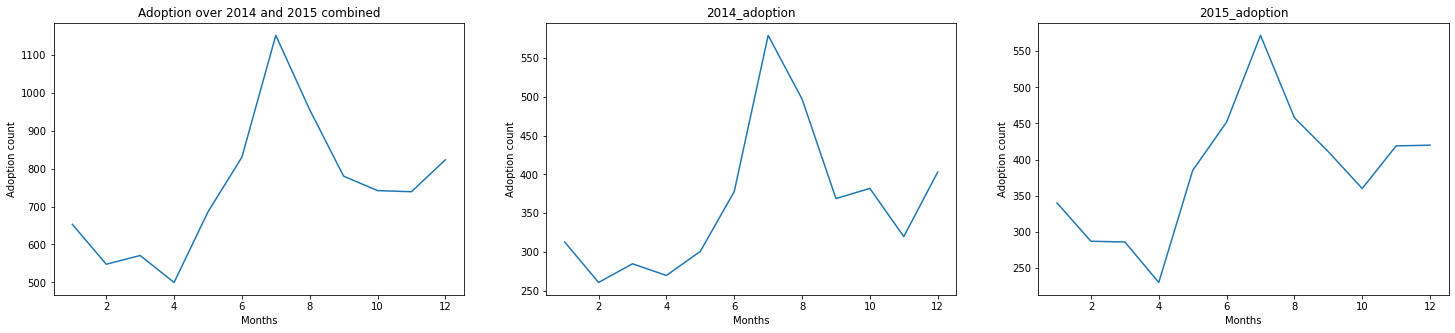

In [33]:
import matplotlib.pyplot as plt

adoption_trend = adoption['month'].value_counts().sort_index()
adoption_2014 = adoption.loc[adoption['year'] == 2014, 'month'].value_counts().sort_index()
adoption_2015 = adoption.loc[adoption['year'] == 2015, 'month'].value_counts().sort_index()

plt.figure(figsize = (25,5))

#Cumulative over 2014 and 2015 
plt.subplot(1,3,1)
adoption_trend.plot(kind = 'line')
plt.title('Adoption over 2014 and 2015 combined')
plt.xlabel('Months')
plt.ylabel('Adoption count')

#2014
plt.subplot(1,3,2)
adoption_2014.plot(kind = 'line')
plt.title('2014_adoption')
plt.xlabel('Months')
plt.ylabel('Adoption count')

#2015
plt.subplot(1,3,3)
adoption_2015.plot(kind = 'line')
plt.title('2015_adoption')
plt.xlabel('Months')
plt.ylabel('Adoption count')

plt.show()

It can be inferred from the graphs that the adoptions
- are maximum during the mid-year months
- they fall to about half the mid-year strength during the months following mid-year and
- they become an all time low during the beginning of each year

### Plotting transfer trend:

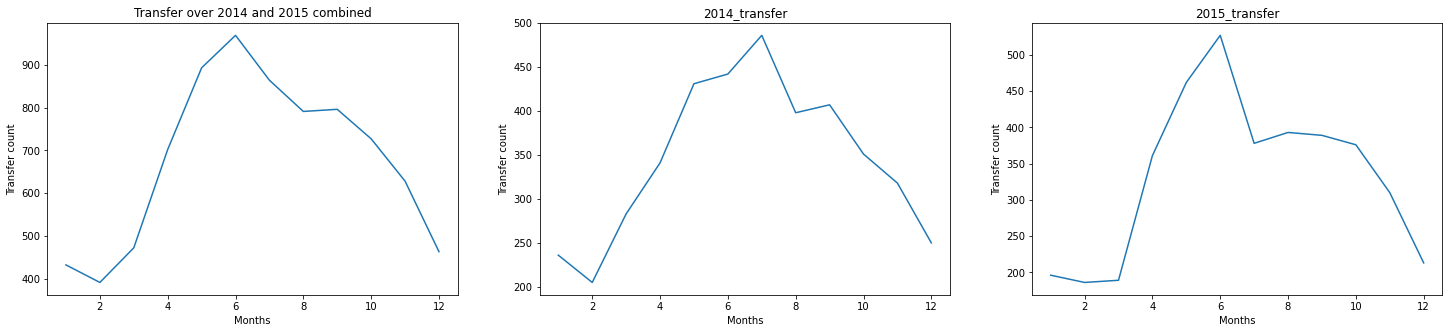

In [34]:
transfer = df[df['outcome_type'] == 'Transfer']
transfer_trend = transfer['month'].value_counts().sort_index()
transfer_2014 = transfer.loc[transfer['year'] == 2014, 'month'].value_counts().sort_index()
transfer_2015 = transfer.loc[transfer['year'] == 2015, 'month'].value_counts().sort_index()

plt.figure(figsize = (25,5))

#Cumulative over 2014 and 2015
plt.subplot(1,3,1)
transfer_trend.plot(kind = 'line')
plt.title('Transfer over 2014 and 2015 combined')
plt.xlabel('Months')
plt.ylabel('Transfer count')

#2014
plt.subplot(1,3,2)
transfer_2014.plot(kind = 'line')
plt.title('2014_transfer')
plt.xlabel('Months')
plt.ylabel('Transfer count')

#2015
plt.subplot(1,3,3)
transfer_2015.plot(kind = 'line')
plt.title('2015_transfer')
plt.xlabel('Months')
plt.ylabel('Transfer count')

plt.show()

Animal transfer trend roughly follows the same pattern as adoption trend.

## Cats and dogs outcomes:

What is the **ratio of cats and dogs** in the shelter?

In [16]:
df['type'].value_counts()/total

Dog    0.574228
Cat    0.425772
Name: type, dtype: float64

Dogs comprise about 60% and cats comprise about 40% of the animals in the shelter therefore they are in a ratio of 3:2 respectively.

In [17]:
dogs = df[df['type'] == 'Dog']
cats = df[df['type'] == 'Cat']

dogs_outcome = dogs['outcome_type'].value_counts().sort_index()/dogs.shape[0]
cats_outcome = cats['outcome_type'].value_counts().sort_index()/cats.shape[0]

print('DOGS OUTCOME:')
print(dogs_outcome)
print('\n')
print('CATS OUTCOME:')
print(cats_outcome)

DOGS OUTCOME:
Adoption           0.416923
Died               0.003305
Euthanasia         0.054565
Return_to_owner    0.277513
Transfer           0.247694
Name: outcome_type, dtype: float64


CATS OUTCOME:
Adoption           0.368263
Died               0.013474
Euthanasia         0.064677
Return_to_owner    0.045191
Transfer           0.508396
Name: outcome_type, dtype: float64


It can be seen that less than half the dogs and cats get adopted. Over half the cats are transfered but only about a quarter of the dogs are transfered. This gives us an impression that this is a **more dog-friendly/ dog-facilities enhanced shelter**.

## Gender role in adoption:

In [18]:
def gender(element):
    return str.split(str(element))[-1]

df['gender'] = df['sex'].apply(gender)

print('Male & female animals proportion in the shelter:')
df['gender'].value_counts()/total

Male & female animals proportion in the shelter:


Male       0.496161
Female     0.457590
Unknown    0.046249
Name: gender, dtype: float64

In [19]:
dogs_adopt = df[(df['type'] == 'Dog') & (df['outcome_type'] == 'Adoption')]
cats_adopt = df[(df['type'] == 'Cat') & (df['outcome_type'] == 'Adoption')]

print('ADOPTION DETAILS:')
print('Male dogs:   ', dogs_adopt[dogs_adopt['gender'] == 'Male'].shape[0]/dogs_adopt.shape[0])
print('Female dogs: ', dogs_adopt[dogs_adopt['gender'] == 'Female'].shape[0]/dogs_adopt.shape[0])
print('Male cats:   ', cats_adopt[cats_adopt['gender'] == 'Male'].shape[0]/cats_adopt.shape[0])
print('Female cats: ', cats_adopt[cats_adopt['gender'] == 'Female'].shape[0]/cats_adopt.shape[0])

ADOPTION DETAILS:
Male dogs:    0.5054377880184332
Female dogs:  0.4945622119815668
Male cats:    0.49000844356881507
Female cats:  0.5099915564311849


Regardless of gender, about half of all dogs and cats seem to be adopted.

## Popular breeds in the shelter:

In [20]:
df['breed'].describe()

count                      22660
unique                      1269
top       Domestic Shorthair Mix
freq                        7657
Name: breed, dtype: object

There are over **1269 unique breeds** and the topmost breed seems to form about 1/3rd of all the animals in the shelter. Since there are a lot of unique values, using Series.value_counts() function for all the values in the column would not be of much help. So we use the function to view only the most predominant breeds.

In [21]:
print('TOP 10 BREEDS:')
df['breed'].value_counts().head(10)

TOP 10 BREEDS:


Domestic Shorthair Mix       7657
Pit Bull Mix                 1561
Chihuahua Shorthair Mix      1470
Labrador Retriever Mix       1100
Domestic Medium Hair Mix      717
German Shepherd Mix           469
Domestic Longhair Mix         448
Siamese Mix                   334
Australian Cattle Dog Mix     298
Dachshund Mix                 257
Name: breed, dtype: int64

Since the **top few breeds** are huge in numbers, **their proportion** in the shelter are calculated as follows:

In [22]:
round(df['breed'].value_counts().head().sum()/total, 2)

0.55

Just the **top 5 breeds out of 1269 unique breeds** in the shelter seems to be constituting **OVER HALF** the total animals!

### Interesting analysis about the top animal -  The Domestic Shorthair Mix

In [23]:
print('Type of animal: ', df[df['breed'] == 'Domestic Shorthair Mix']['type'].unique())
print('Its percantage in the shelter: ', df[df['breed'] == 'Domestic Shorthair Mix'].shape[0]/total)
print('Its percentage among cats :', df[df['breed'] == 'Domestic Shorthair Mix'].shape[0]/cats.shape[0])

Type of animal:  ['Cat']
Its percantage in the shelter:  0.3379082082965578
Its percentage among cats : 0.7936359867330016


The 'Domestic Shorthair Mix' is a cat breed and it forms over **30% of the total population** and about **80% of the total cats** in the shelter.

What is the outcome for this breed?

In [24]:
cats.loc[cats['breed'] == 'Domestic Shorthair Mix', 'outcome_type'].value_counts()/cats[cats['breed'] == 'Domestic Shorthair Mix'].shape[0]

Transfer           0.531670
Adoption           0.353663
Euthanasia         0.062035
Return_to_owner    0.039572
Died               0.013060
Name: outcome_type, dtype: float64

Over half the cats of this breed seem to be transfered to another partnering shelter and about 35% of them are adopted.

#### Cat breeds analysis:
Checking the other cat breeds:

In [25]:
cats['breed'].value_counts().head()/cats.shape[0]

Domestic Shorthair Mix      0.793636
Domestic Medium Hair Mix    0.074316
Domestic Longhair Mix       0.046434
Siamese Mix                 0.034619
Domestic Shorthair          0.013163
Name: breed, dtype: float64

The other cat breeds don't seem to have a significant impact on total cat population.

#### Dog breeds analysis:
Analysing the top dog breeds:

In [26]:
dogs['breed'].value_counts().head(10)

Pit Bull Mix                 1561
Chihuahua Shorthair Mix      1470
Labrador Retriever Mix       1100
German Shepherd Mix           469
Australian Cattle Dog Mix     298
Dachshund Mix                 257
Boxer Mix                     210
Miniature Poodle Mix          191
Border Collie Mix             189
Australian Shepherd Mix       137
Name: breed, dtype: int64

Unlike the top cat breed, the **dog breeds are more distributed** rather than one value predominating the entire population. This gives us an impression that either:

- domestic shorthair mix cats are the most common cats in the area (or)
- it **might not be easy to differentiate cat breeds as easily as dog breeds** since dogs naturally have a lot of variations like body built, face structures etc.,

Cumulative proportion of the first few dog breeds:

In [27]:
print('Percentage of the top 10 dog breeds among total dogs: ', dogs['breed'].value_counts().head(10).sum()/dogs.shape[0])
print('Percentage of the top 10 dog breeds in the shelter: ', dogs['breed'].value_counts().head(10).sum()/total)

Percentage of the top 10 dog breeds among total dogs:  0.4520442668306179
Percentage of the top 10 dog breeds in the shelter:  0.259576345984113


The top 10 breeds take about 50% of the dogs and form about a quarter of the total shelter population

## Fertility vs adoption/ transfer:

In [28]:
adoption['sex'].value_counts(dropna=False)/df['sex'].value_counts(dropna=False)

Intact Female    0.055757
Intact Male      0.043436
Neutered Male    0.533096
Spayed Female    0.589534
Unknown               NaN
Name: sex, dtype: float64

In [29]:
transfer['sex'].value_counts(dropna=False).sort_index()/df['sex'].value_counts(dropna=False).sort_index()

Intact Female    0.728802
Intact Male      0.668071
Neutered Male    0.197843
Spayed Female    0.180431
Unknown          0.877863
Name: sex, dtype: float64

It can clearly be seen that **over half the sterile animals are adopted**. So sterile animals have a better shot becoming pets. But this is opposite in case of transfers, whereas fertile animals are transfered and sterile animals are kept in the shelter to be put up for adoption. About 90% of the animals whose genders are marked 'Unknown' are also transfered.

## Age analysis:

In [30]:
df['age'].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '3 months',
       '2 weeks', '2 months', '5 years', '7 years', '4 months', '3 years',
       '4 years', '12 years', '9 years', '1 weeks', '11 years', '6 years',
       '6 months', '4 weeks', '7 months', '8 years', '10 months',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '1 day', '13 years', '16 years',
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

Since the range is huge, the animals are sorted into two categories namely:
- Little (age < 1 year)
- Big (age > 1 year)

In [31]:
pd.options.mode.chained_assignment = None  # default='warn' - to avoid SettingWithCopyWarning

def age_calc(element): 
    if 'year' in element:
        return 'Big'
    return 'Little'

adoption['ages'] = adoption['age'].apply(age_calc)
adoption['ages'].value_counts()

Little    4812
Big       4166
Name: ages, dtype: int64

In [32]:
big = adoption[adoption['ages'] == 'Big']
little = adoption[adoption['ages'] == 'Little']

print('Adoption ratio:')
print('Big:    ', big.shape[0]/adoption.shape[0])
print('Little: ', little.shape[0]/adoption.shape[0])

Adoption ratio:
Big:     0.4640231677433727
Little:  0.5359768322566273


The 'Big' and the 'Little' category animals both seems to be having a fair shot at getting adopted. But this step is open for futher analysis in the future.

## Conclusion:
To answer the questions posed in the beginning of the project:
- Mid-year is the peak time for adoption and transfers
- Dogs and cats are equally adopted
- Male and female dogs and cats are also equally adopted
- The top cat breed (Domestic shorthair) forms about 80% of the total cats and 30% of the animals in the entire shelter. Dog breeds are more distributed unlike cats.
- Sterile pets are preferred for pet adoption
- First-degree analysis of age shows equal chances of adoption